# Decision Trees

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The first steps are identical as in exercise 3. We will import the dataset and display some records and later we will define the explanatory variables and target variable.

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df = pd.read_csv(url, delimiter=',', names=[
    'Class',
    'Alcohol',
    'Malic acid',
    'Ash',
    'Alcalanity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'])

df.head()

,Class,Alcohol,Malic acid,Ash,Alcalanity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

Now we will create basic Decision Tree classifier with default Gini index as criterion for quality of splits. It describes how homogenous a node is. A node is pure when all its samples belong to one class having Gini impurity $G$ equal to 0. On the other side a node with samples from many different classes will have $G$ closer to 1. Formally it's defined as:

\begin{equation}
G = 1 - \sum_{k = 1}^{n}\pi_{k},
\end{equation}

where $\pi_{k}$ is prior probability of a given class. To check the performance of the model we will calculate in-sample accuracy and cross validation accuracy.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X, y)

print('In-sample accuracy: {}'.format(clf.score(X, y)))
print('Cross validation accuracy: {}'.format(cross_val_score(clf, X, y, cv=10).mean()))

In-sample accuracy: 1.0
Cross validation accuracy: 0.8705882352941178


As expected in-sample accuracy takes very high value, while cross validation accuracy has worse result. Later we will try to improve this model such that it will generalize better by pruning the tree. But now we will visualize a tree model with a simple function that uses embedded method `plot_tree()`.

In [5]:
def draw_tree(clf, size):
    plt.figure(figsize=size)
    tree.plot_tree(clf)
    plt.show()

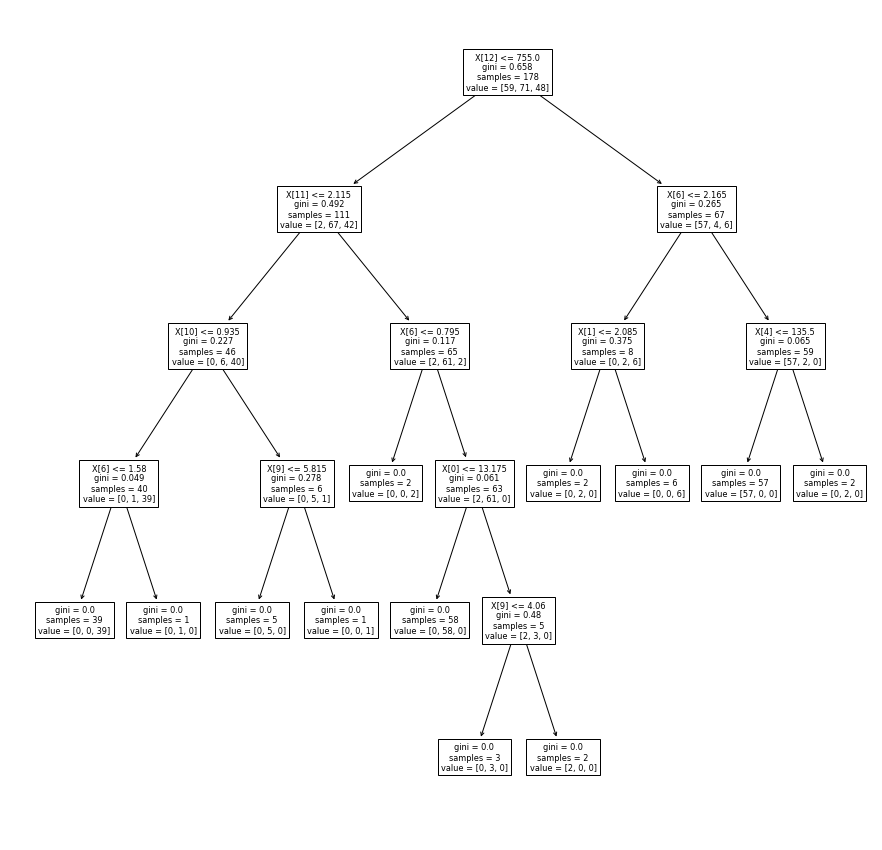

In [6]:
draw_tree(clf, (15, 15))

For each node there is a splitting condition, value of Gini impurity, total number of samples and list of values that tells us how many of the samples fall into each of the classes. In the next step we will employ minimal cost-complexity pruning to choose optimal tree and avoid overfitting. By applying this algorithm to the large tree we obtain a sequence of impurities of the subtree leaves as a function of effective complexity parameter $\alpha_{eff}$. Next we create the subtrees for each value of $\alpha$, use cross validation for model evaluation and choose the $\alpha$ which the subtree has the maximum accuracy for. Finally we get the subtree corresponding to the chosen $\alpha$ value.

In [7]:
def get_optimal_tree(clf, X_train, y_train):
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas
    
    cv_scores = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        score = cross_val_score(clf, X_train, y_train, cv=10).mean()
        cv_scores.append(score)

    optimal_ccp = ccp_alphas[np.argmax(cv_scores)]
    optimal_clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=optimal_ccp)
    accuracy = cv_scores[np.argmax(cv_scores)]

    return optimal_clf, accuracy

We can use the function that we defined just now to generate the optimal subtree, check its accuracy and visualize it.

Accuracy: 0.8830065359477125


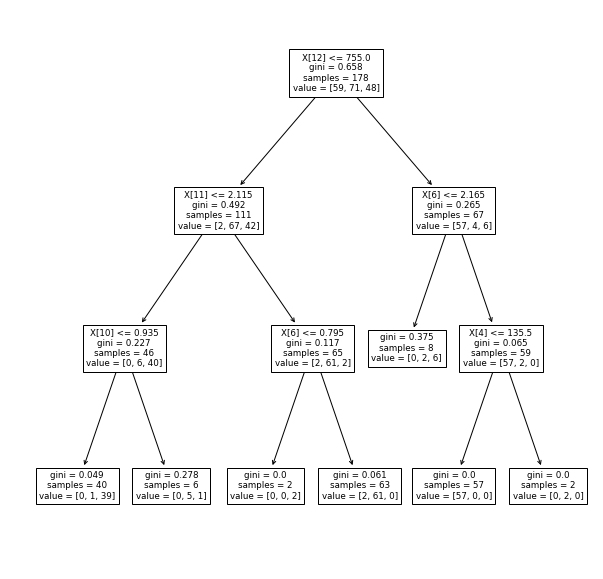

In [8]:
optimal_clf, accuracy = get_optimal_tree(clf, X, y)
optimal_clf.fit(X, y)

print('Accuracy: {}'.format(accuracy))
draw_tree(optimal_clf, (10, 10))

The accuracy of the optimal model has been slightly increased in comparison with the large tree. Moreover the model generalizes better since it's been pruned. Now we will improve our model even more by selecting the optimal number of features. To do so, a new tree model will be created which will be fit on the different number of features each time and the optimal tree with its accuracy will be obtained and stored in a list. Also a difference between the depths of the large tree and optimal tree will be tracked.

In [9]:
accuracy_list, differences = [], []
for i in range(2, 15):
    X = df.iloc[:, 1:i]
    y = df.iloc[:, 0]
    
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf.fit(X, y)
    
    optimal_clf, accuracy = get_optimal_tree(clf, X, y)
    optimal_clf.fit(X, y)
    
    differences.append(clf.get_depth() - optimal_clf.get_depth())
    accuracy_list.append(accuracy)

In the following section we will plot the results in a function of the number of features.

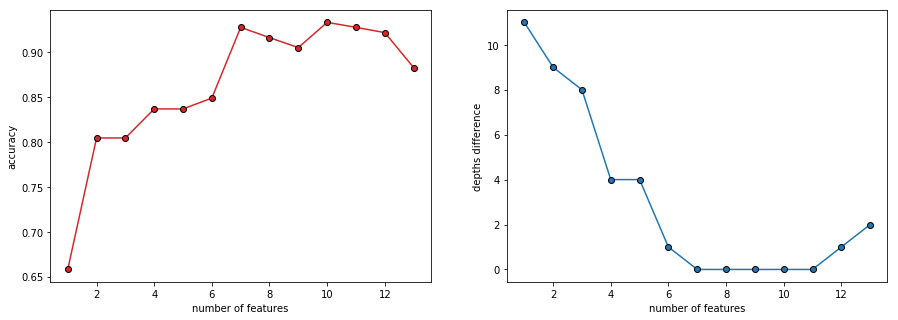

In [10]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('number of features')
ax1.set_ylabel('accuracy')
plt.plot(range(1, 14), accuracy_list, color='tab:red', marker='o', markeredgecolor='black')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('number of features')
ax2.set_ylabel('depths difference')
plt.plot(range(1, 14), differences, color='tab:blue', marker='o', markeredgecolor='black')

plt.show()

We can conclude that the optimal number of features is 10 – the model reaches almost 95% of accuracy. We can also see that for small number of features the model is underfitted, its accuracy is low and the depths difference is huge. On the other hand for greater number of features than 10 model is getting overfitted – accuracy decreases and depths difference increases.